# Explore here

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
import requests

In [2]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv"
response = requests.get(url)

if response.status_code == 200:
    with open('/workspace/machine-learning/data/raw/downloaded_file.csv', 'wb') as file:
        file.write(response.content)
    print("CSV file downloaded successfully.")

CSV file downloaded successfully.


In [3]:
df = pd.read_csv('/workspace/machine-learning/data/raw/downloaded_file.csv').iloc[:,1:]
pd.set_option('display.max_columns', None)
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [4]:
df.tail()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
48890,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2
48894,Trendy duplex in the very heart of Hell's Kitchen,68119814,Christophe,Manhattan,Hell's Kitchen,40.76404,-73.98933,Private room,90,7,0,NaN,NaN,1,23


In [5]:
df.shape

(48895, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month               

In [7]:
# We consider that we don't need the column host_name, name, host_id, last_review, reviews_per_month, neighbourhood_group.
df.drop(columns = ["host_name", "name", "host_id","last_review","reviews_per_month","neighbourhood_group"], inplace = True)

In [8]:
df.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365
1,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365
3,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


In [9]:
# We confirm the columns were erased correctly.
print(df.columns)

Index(['neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


In [10]:
# We check if there are duplicate rows.
print(df.duplicated().sum())

0


In [11]:
# We check which columns have a NAN value.
df.isnull().any(axis=0)

neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
calculated_host_listings_count    False
availability_365                  False
dtype: bool

In [12]:
# We create a new table to identify the listings that have a review.
df['has_review'] = (df['number_of_reviews']>0).astype(int)

In [13]:
df.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,has_review
0,Kensington,40.64749,-73.97237,Private room,149,1,9,6,365,1
1,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,355,1
2,Harlem,40.80902,-73.94190,Private room,150,3,0,1,365,0
3,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,1,194,1
4,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,0,1


In [14]:
a = df['room_type'].unique()
a

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [15]:
# We will specify the values in the mapping (0 = shared room, 1 = private room, 2 = house).
mapping = {'Shared room': 0, 'Private room': 1, 'Entire home/apt': 2}

df['room_type'] = df['room_type'].map(mapping)

In [16]:
# We check the dataframe.
df.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,has_review
0,Kensington,40.64749,-73.97237,1,149,1,9,6,365,1
1,Midtown,40.75362,-73.98377,2,225,1,45,2,355,1
2,Harlem,40.80902,-73.94190,1,150,3,0,1,365,0
3,Clinton Hill,40.68514,-73.95976,2,89,1,270,1,194,1
4,East Harlem,40.79851,-73.94399,2,80,10,9,1,0,1


In [17]:
# We will now do target encoding for the neighbourhood. 
df['room_type_str'] = df['room_type'].astype(str) #We create a new column to 
# We will take into account the room type for the mean value of the neighbourhood.
df['neighbourhood_room_type'] = df['neighbourhood'] + '_' + df['room_type_str']


In [18]:
df.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,has_review,room_type_str,neighbourhood_room_type
0,Kensington,40.64749,-73.97237,1,149,1,9,6,365,1,1,Kensington_1
1,Midtown,40.75362,-73.98377,2,225,1,45,2,355,1,2,Midtown_2
2,Harlem,40.80902,-73.94190,1,150,3,0,1,365,0,1,Harlem_1
3,Clinton Hill,40.68514,-73.95976,2,89,1,270,1,194,1,2,Clinton Hill_2
4,East Harlem,40.79851,-73.94399,2,80,10,9,1,0,1,2,East Harlem_2


In [19]:
# We now calculate the average price for each neighborhood and room type combination
avg_prices = df.groupby('neighbourhood_room_type')['price'].mean()

In [20]:
# We now add the average prices back to the original dataframe
df['neighbourhood_encoding'] = df['neighbourhood_room_type'].map(avg_prices)

In [21]:
df.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,has_review,room_type_str,neighbourhood_room_type,neighbourhood_encoding
0,Kensington,40.64749,-73.97237,1,149,1,9,6,365,1,1,Kensington_1,59.377551
1,Midtown,40.75362,-73.98377,2,225,1,45,2,355,1,2,Midtown_2,301.268182
2,Harlem,40.80902,-73.94190,1,150,3,0,1,365,0,1,Harlem_1,81.950413
3,Clinton Hill,40.68514,-73.95976,2,89,1,270,1,194,1,2,Clinton Hill_2,243.982659
4,East Harlem,40.79851,-73.94399,2,80,10,9,1,0,1,2,East Harlem_2,189.545267


In [22]:
# We will compare the kensington neighborhood
df.loc[df['neighbourhood_room_type'] == 'Midtown_1']

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,has_review,room_type_str,neighbourhood_room_type,neighbourhood_encoding
618,Midtown,40.75575,-73.96842,1,110,2,61,1,264,1,1,Midtown_1,244.42891
943,Midtown,40.74553,-73.98943,1,135,3,214,2,167,1,1,Midtown_1,244.42891
997,Midtown,40.74530,-73.99056,1,145,3,165,2,181,1,1,Midtown_1,244.42891
1439,Midtown,40.74648,-73.98459,1,100,3,41,1,0,1,1,Midtown_1,244.42891
1539,Midtown,40.76221,-73.97787,1,120,4,31,1,0,1,1,Midtown_1,244.42891
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47967,Midtown,40.76384,-73.98248,1,125,1,6,1,142,1,1,Midtown_1,244.42891
48000,Midtown,40.75258,-73.97111,1,134,30,0,12,365,0,1,Midtown_1,244.42891
48023,Midtown,40.75669,-73.96848,1,100,2,0,1,89,0,1,Midtown_1,244.42891
48576,Midtown,40.75286,-73.99297,1,120,2,1,1,7,1,1,Midtown_1,244.42891


In [23]:
# WE DROP THE COLUMNS THAT ARE NOT NECESSARY ANYMORE.
df.drop(columns = ["neighbourhood", "room_type_str", "neighbourhood_room_type"], inplace = True)
df.head()

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,has_review,neighbourhood_encoding
0,40.64749,-73.97237,1,149,1,9,6,365,1,59.377551
1,40.75362,-73.98377,2,225,1,45,2,355,1,301.268182
2,40.80902,-73.94190,1,150,3,0,1,365,0,81.950413
3,40.68514,-73.95976,2,89,1,270,1,194,1,243.982659
4,40.79851,-73.94399,2,80,10,9,1,0,1,189.545267


In [24]:
# We check if there are any prices with value 0.
df[df['price'] == 0]

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,has_review,neighbourhood_encoding
23161,40.69023,-73.95428,1,0,4,1,4,28,1,73.296860
25433,40.83296,-73.88668,1,0,2,55,4,127,1,67.142857
25634,40.69467,-73.92433,1,0,2,16,5,0,1,62.623037
25753,40.72462,-73.94072,1,0,2,12,2,0,1,88.462185
25778,40.70838,-73.94645,2,0,5,3,1,73,1,206.094130
25794,40.68173,-73.91342,1,0,1,93,6,176,1,73.296860
25795,40.68279,-73.91170,1,0,1,95,6,232,1,73.296860
25796,40.68258,-73.91284,1,0,1,95,6,222,1,73.296860
26259,40.75091,-73.97597,2,0,3,0,1,0,0,237.852130
26841,40.69211,-73.90670,0,0,30,2,6,333,1,37.382353


In [25]:
# we erase all the rows with price = 0 as ti will not give us any valuable data.
indices_a_eliminar = df[df['price'] == 0].index

# Eliminando las filas
df = df.drop(indices_a_eliminar)

# We confirm there are no price = 0 value in the dataframe.
df[df['price'] == 0]

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,has_review,neighbourhood_encoding


In [26]:
df.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
latitude,48884.0,40.729,0.055,40.500,40.690,40.723,40.763,40.913
longitude,48884.0,-73.952,0.046,-74.244,-73.983,-73.956,-73.936,-73.713
room_type,48884.0,1.496,0.545,0.000,1.000,2.000,2.000,2.000
price,48884.0,152.755,240.170,10.000,69.000,106.000,175.000,10000.000
minimum_nights,48884.0,7.030,20.512,1.000,1.000,3.000,5.000,1250.000
number_of_reviews,48884.0,23.272,44.551,0.000,1.000,5.000,24.000,629.000
calculated_host_listings_count,48884.0,7.145,32.956,1.000,1.000,1.000,2.000,327.000
availability_365,48884.0,112.779,131.627,0.000,0.000,45.000,227.000,365.000
has_review,48884.0,0.794,0.404,0.000,1.000,1.000,1.000,1.000
neighbourhood_encoding,48884.0,152.734,80.738,13.000,81.950,137.270,216.908,803.500


In [27]:
# We notice how the 75% percentile of prices is 175, however, the maximum value is 10.000, which is probably an outlier.
# We notice how the max value minimum_nights is 1250, however, there is only 365 days, there fore we will set that value as a maximum value - we will replace all the values above 365 as 365, and as well, the 75% is 5, making it probably an outlier.
# We notice as well how the outlier in neighbourhood_encoding could be generated from the price outliers, as the way we got that value, was dependent on the price. If we decide to get rid of the outliers, we should step back and remove those values from the neighbourhood encoding formula.

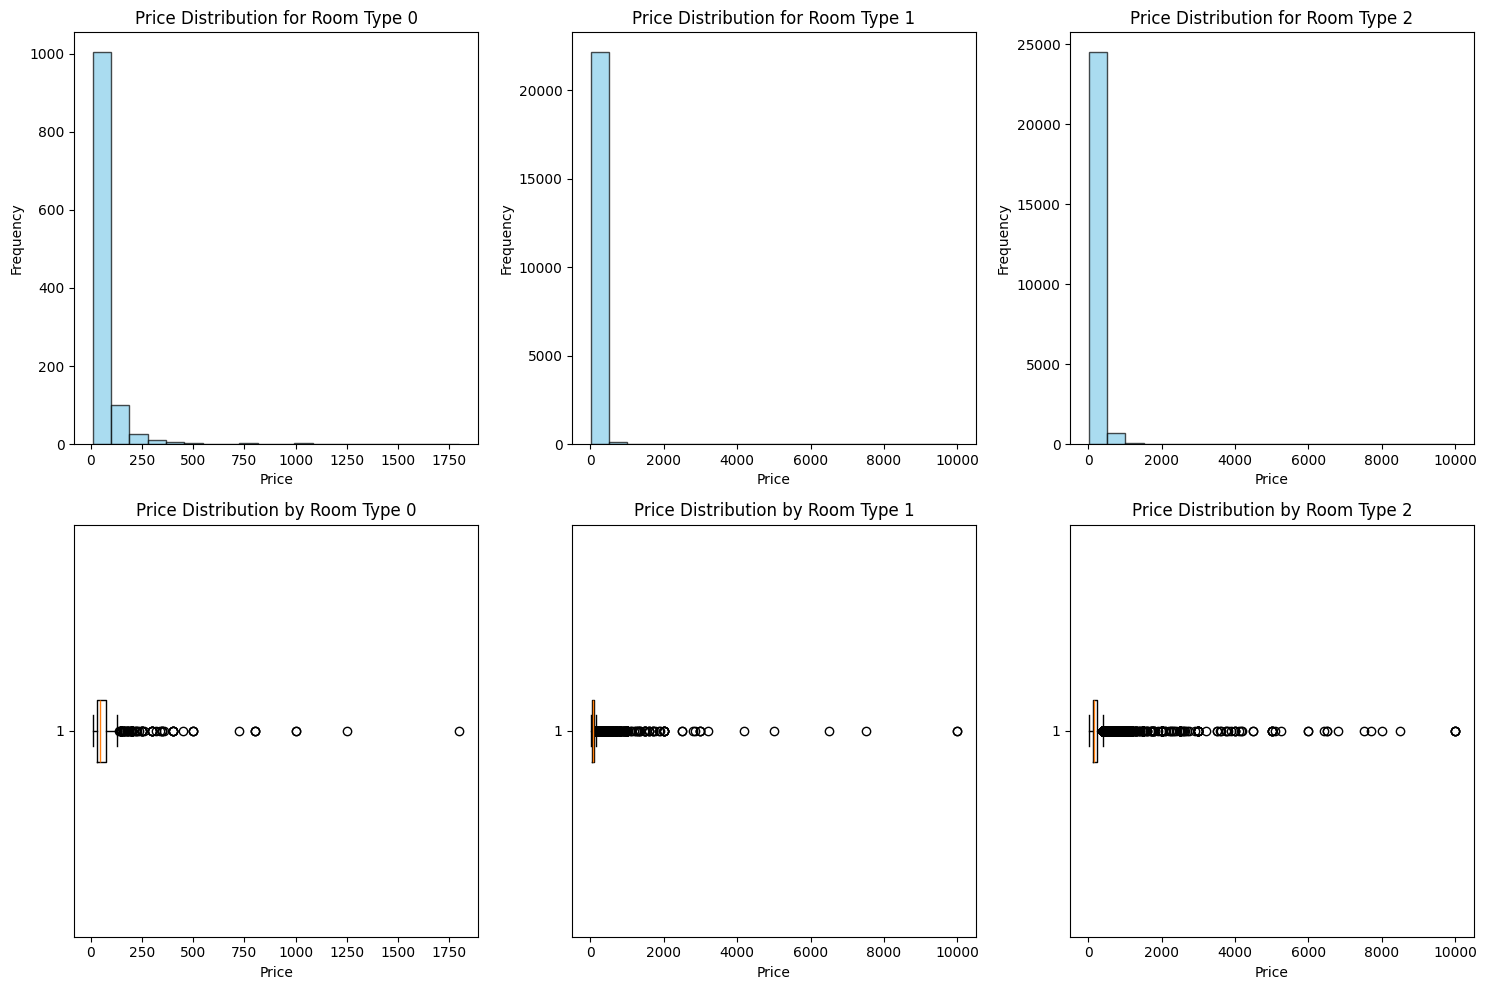

In [31]:
# WE CHECK THE PRICE DISTRIBUTION, AS THERE ARE THREE DIFFERENT TYPES OF RENTAL, WE SHOULD CHECK THEM SEPARATELY.
room_types = sorted(df['room_type'].unique())

# Create a figure with two rows - one for histograms, one for boxplots
fig, ax = plt.subplots(2, len(room_types), figsize=(15, 10))  # Adjust figure size as needed

# Iterate through room types and create histograms and boxplots
for i, room_type in enumerate(room_types):
    # Filter data for the current room type
    room_type_data = df[df['room_type'] == room_type]['price']

    # Create a histogram in the first row
    ax[0, i].hist(room_type_data, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax[0, i].set_title(f'Price Distribution for Room Type {room_type}')
    ax[0, i].set_xlabel('Price')
    ax[0, i].set_ylabel('Frequency')

    # Create a boxplot in the second row
    ax[1, i].boxplot(room_type_data, vert=False)
    ax[1, i].set_title(f'Price Distribution by Room Type {room_type}')
    ax[1, i].set_xlabel('Price')

# Adjust layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [32]:
# We will take the log price to obtain a clearer view.
df['Log_Price'] = np.log(df.price)

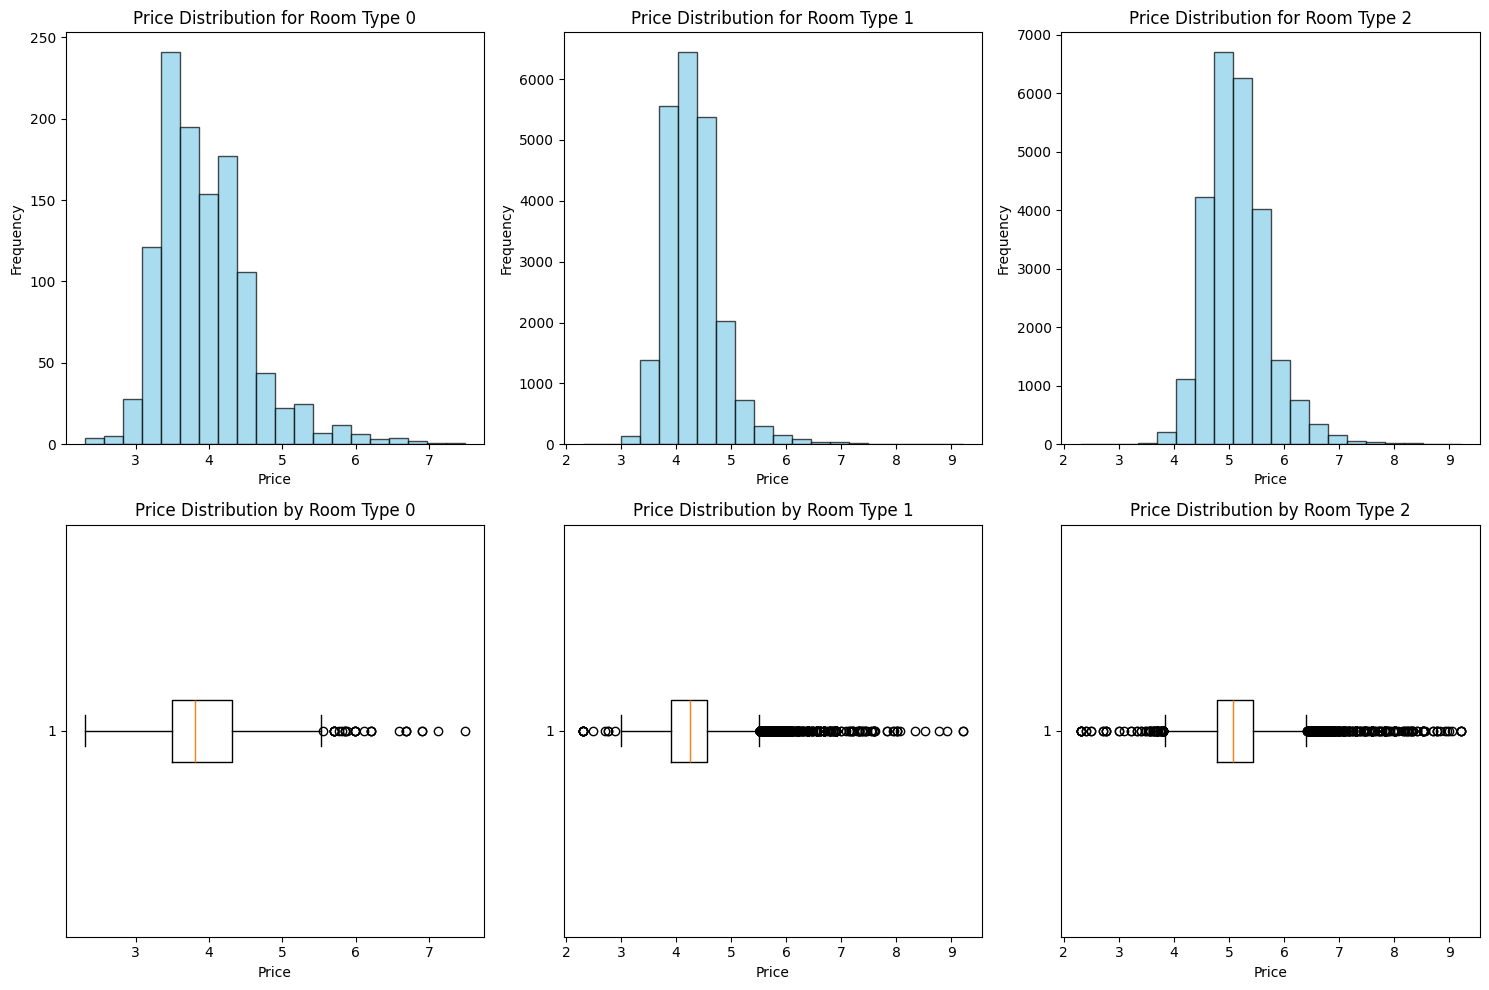

In [33]:
# Create a figure with two rows - one for histograms, one for boxplots
fig, ax = plt.subplots(2, len(room_types), figsize=(15, 10))  # Adjust figure size as needed

# Iterate through room types and create histograms and boxplots
for i, room_type in enumerate(room_types):
    # Filter data for the current room type
    room_type_data = df[df['room_type'] == room_type]['Log_Price']

    # Create a histogram in the first row
    ax[0, i].hist(room_type_data, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax[0, i].set_title(f'Price Distribution for Room Type {room_type}')
    ax[0, i].set_xlabel('Price')
    ax[0, i].set_ylabel('Frequency')

    # Create a boxplot in the second row
    ax[1, i].boxplot(room_type_data, vert=False)
    ax[1, i].set_title(f'Price Distribution by Room Type {room_type}')
    ax[1, i].set_xlabel('Price')

# Adjust layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [34]:
# We check if there is any values missing.
df.isnull().mean()*100

latitude                          0.0
longitude                         0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
has_review                        0.0
neighbourhood_encoding            0.0
Log_Price                         0.0
dtype: float64

In [36]:
# Variables independientes/dependiente
X = df.drop(['Log_Price'], axis=1)
y = df.Log_Price

# Ajusta el modelo
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance

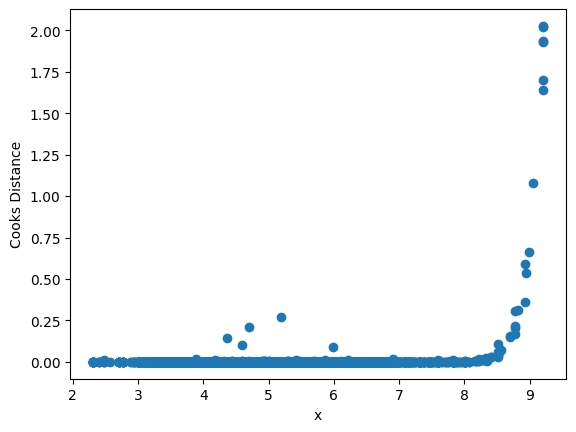

In [37]:
plt.scatter(df.Log_Price, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

We are considering to address the potential outliers to improve the model's fit and robustness.

In [46]:
np.where(cooks_distance[0]>0.4)

(array([ 4377,  6530,  9151, 12342, 17692, 29227, 29651, 30257, 40422,
        42512]),)

In [47]:
# We check the values to detect if there are any clear outliers and make a decision about them.
df.loc[[ 4377,  6530,  9151, 12342, 17692, 29227, 29651, 30257, 40422, 42512]]

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,has_review,neighbourhood_encoding,Log_Price
4377,40.69137,-73.96723,2,8000,1,1,11,365,1,243.982659,8.987197
6530,40.79264,-73.93898,2,9999,5,1,1,0,1,189.545267,9.210240
9151,40.76810,-73.91651,1,10000,100,2,1,0,1,96.178138,9.210340
12342,40.71355,-73.98507,1,9999,99,6,1,83,1,134.054496,9.210240
17692,40.73260,-73.95739,2,10000,5,5,1,0,1,190.115756,9.210340
29227,40.69741,-73.89895,1,38,4,0,1,0,0,56.260563,3.637586
29651,40.66658,-73.76581,2,228,2,4,2,0,1,126.000000,5.429346
30257,40.71782,-73.96318,2,1000,1,0,4,179,0,206.094130,6.907755
40422,40.75483,-73.99689,2,135,4,0,1,0,0,254.242628,4.905275
42512,40.72222,-73.99692,1,150,14,3,1,36,1,112.752941,5.010635


We decide that 4377, 6530, 9151, 12342, 17692 and 30257 for their price is more than x5 times the neighbourhood_encoding (their group average)

In [54]:
df.drop([4377,  6530,  9151, 12342, 17692, 30257], inplace=True) # AFTER DOING SO IT DIDN'T CHANGE MUCH.....

We will now observe how the data displayed changes.